![](images/spam-unsplash-hannes_johnson.jpg){fig-align="center"}

<center><a href = "https://unsplash.com/photos/mRgffV3Hc6c">Unsplash | Hannes Johnson</a></center>

# Introduction

The Multinomial Naive Bayes Algorithm is a machine learning algorithm based on the Bayes Theorem. It calculates the probability that an event $B$ occurred given that event $A$ occurred. Thus, it is usually used in classification problems. (Vadapalli, 2021)

In this project, we will use the algorithm to determine the probability that a message is spam given its contents. We will then use this probability to decide whether to treat new messages as spam or not. For example, if the probability of being spam is over 50%, then we may treat the message as spam.

Identifying spam is important in the Philippines because phishing campaigns went up by 200% after the pandemic began (Devanesan, 2020), and a telecommunications provider recently had to block around 71 million spam messages (Yap, 2021). Such messages may attempt to steal personal information, steal money from an account, or install malware (FTC, 2020). Thus, machine learning can be a very helpful tool in preventing such harm from occurring.

Though the algorithm can be easily implemented using existing functions such as those in the [scikit-learn package](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), I will manually code the algorithm step-by-step in order to explain the mathematical intuition behind it.

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Building a Spam Filter with Naive Bayes](https://app.dataquest.io/c/74/m/433/guided-project%3A-building-a-spam-filter-with-naive-bayes/1/exploring-the-dataset) The general project flow came from Dataquest. The mathematical explanations are also based on what I learned from Dataquest.

:::

# Packages

Below are the packages necessary for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# The Dataset

We will use the SMS Spam Collection Dataset by Almeida and Hidalgo in 2012. It can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).



In [2]:
#| code-fold: true
sms_df = pd.read_csv(
    "./private/Naive-Bayes-Files/SMSSpamCollection",
    # Tab-separated
    sep = "\t",
    header = None,
    names = ["label", "sms"]
)

sms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


The dataset has 2 columns and 5572 rows.

- The `label` column contains "ham" if the message is legitimate, or "spam" if it is spam.
- The `sms` column contains individual SMS messages.

For example, below are the first 5 rows of the dataset.

In [3]:
#| code-fold: true
sms_df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Training and Testing Sets

The messages will be split into two sets. The training set, comprising 80% of the total data, will be used to train the Naive Bayes Algorithm. The testing set, with 20% of the total data, will be used to test the model's accuracy.

First, however, let us calculate what percentage of the messages in the dataset are spam.

In [4]:
#| code-fold: true
spam_perc = sms_df["label"].eq("spam").sum() / sms_df.shape[0] * 100
print(f"Percentage of spam messages: {spam_perc:.2f}%")

Percentage of spam messages: 13.41%


Only 13% of the messages are spam. Therefore, spam and non-spam messages are not equally represented in this dataset, and this may be problematic. However, this is all the data we have, so the best we can do is to ensure that both the training and testing sets have around 13% of their messages as spam.

This is an example of *proportionate stratified sampling* (Thomas, 2020). We first separate the data into two strata (spam and non-spam). We then take 80% of the messages from each strata as the training set. The remaining 20% of each strata is set aside for the testing set. Thus, each of the two sets will contain around 13% spam.

This has been done with the code below.

In [5]:
#| code-fold: true
# Note: I could have used `train_test_split` from sklearn, but I coded this manually for the sake of grasping the logic.
split_lists = {
    "training": [],
    "testing": [],
}

# Stratify the dataset
for label in "spam", "ham":
    stratum = sms_df.loc[sms_df["label"] == label]

    train_part = stratum.sample(
        # Sample 80% of the data points
        frac = 0.8,
        random_state = 1,
    )

    # The other 20% that were not sampled go to the testing set.
    test_part = stratum.loc[~stratum.index.isin(train_part.index)]

    split_lists["training"].append(train_part)
    split_lists["testing"].append(test_part)

split_dfs = pd.Series(dtype = "object")
for key in split_lists:
    # Concatenate spam and non-spam parts into one DataFrame.
    set_df = pd.concat(split_lists[key]).reset_index()
    split_dfs[key] = set_df

    perc_spam = set_df.label.eq('spam').sum() / set_df.shape[0] * 100

    print(f"Number of rows in {key} set: {set_df.shape[0]}")
    print(f"Percentage of {key} messages that are spam: {perc_spam:.2f}%")

Number of rows in training set: 4458
Percentage of training messages that are spam: 13.41%
Number of rows in testing set: 1114
Percentage of testing messages that are spam: 13.38%


We can see that the percentage of spam messages is roughly the same between the two sets. This will help the accuracy of the model later on.

Now, the two sets will be further split into `X` and `y`. `y` refers to the **target**, or the variable that we are trying to predict. In this case, we are trying to predict whether a message is spam or non-spam, so the "label" column is the target:

In [6]:
#| code-fold: true
sms_df.label.head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

On the other hand, `X` refers to the **features**, which are information used to predict the target. We only have one feature column as of now, which is the "sms" column.

In [7]:
#| code-fold: true
sms_df.sms.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: sms, dtype: object


Thus, we end up with four final objects:

- `X_train`: The messages in the training data.
- `X_test`: The messages in the testing data.
- `y_train`: The labels in the training data. These correspond to `X_train`.
- `y_test`: The labels in the testing data. These correspond to `X_test`.

In [8]:
#| code-fold: true
# The four objects listed above.
X_train = split_dfs.training[["sms"]].copy()
X_test = split_dfs.testing[["sms"]].copy()
y_train = split_dfs.training["label"].copy()
y_test = split_dfs.testing["label"].copy()

# The Algorithm

Now, let's discuss the multinomial naive bayes algorithm. Conditional probability is necessary in order to understand it. For our use case, let $Spam$ be the event that a message is spam, and $Ham$ be the event for non-spam.

:::{.callout-note}

The mathematical explanations below are not my own ideas. I learned these from the Dataquest course on Naive Bayes.

:::


## Main Formulas

We want to compare the probability that a given message is spam to the probability that it is ham. Thus, we use the following formulas:

$P(Spam|w_1, w_2, \dots , w_n) \propto P(Spam) \cdot \Pi_{i=1}^n P(w_i|Spam)$

$P(Ham|w_1, w_2, \dots , w_n) \propto P(Ham) \cdot \Pi_{i=1}^n P(w_i|Ham)$

:::{.callout-note}

These formulas are not the same as the Bayes Theorem. To understand how these were derived from the Bayes Theorem, see the Appendix of this post.

:::

These two formulas are identical except for the $Spam$ or $Ham$ event. Let us just look at the first equation to unpack it.

The probability of event $B$ given that event $A$ has happened can be represented as $P(B|A)$ ("probability of B given A"). Thus, the left side of the formula, $P(Spam|w_1, w_2, \dots , w_n)$, represents the probability of spam given the contents of a message. Each variable $w_i$ represents one word in the message. For example, $w_1$ is the first word in the message, and so on.

In the middle, the "directly proportional to" sign ($\propto$) is used instead of the equals sign. The left and right sides are not equal, but one increases as the other increases.

At the right side, $P(Spam)$ simply refers to the probability that any message is spam. It can be calculated as the number of spam messages in the dataset over the total number of messages.

Finally, the formula ends with $\Pi_{i=1}^n P(w_i|Spam)$. The $P(w_i|Spam)$ part refers to the probability of a certain word occurring given that the message is known to be spam. We must calculate this probability for each word in the message. Then, because the uppercase pi ($\Pi$) refers to a product, we must multiply the word probabilities together.

## Additive Smoothing and Vocabulary

In order to calculate $P(w_i|Spam)$, we need to use the following formula:

$P(w_i | Spam) = \frac{N_{w_i | Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}$

We use an almost identical equation for $P(w_i|Ham)$ as well:

$P(w_i | Ham) = \frac{N_{w_i | Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}$

Again, let us just unpack the first formula. $N_{w_i|Spam}$ refers to the number of times that the word appears in the dataset's spam messages.

$\alpha$ is the **additive smoothing parameter**. We will use $\alpha = 1$. This is added to the numerator to prevent it from becoming zero. If it does become zero, the entire product in the main formula will become zero.

$N_{Spam}$ refers to the total number of words in all of the spam messages. Duplicate words are not removed when this is calculated.

Lastly, $N_{Vocabulary}$ refers to the number of words in the **vocabulary**. This is the set of all *unique* words found in any of the messages, whether spam or non-spam. Duplicates are removed.

# Implementation

Based on the theory behind the algorithm, I have written a set of steps to implement it. I will use these steps as the pseudocode for this project.

1. Determine the model **parameters**. These are the variables in the formulas shown earlier. Only the training data will be used for this.
    - Find $P(Spam), P(Ham)$.
        - Divide the number of spam messages by the total number of messages.
        - Do the same for ham messages.
    - Preprocess the messages to focus on individual words.
        - Make all words lowercase.
        - Remove punctuation marks.
    - Form a vocabulary. 
        - Make a set of all the words in the messages, without duplicates.
        - $N_{Vocabulary}$ is the number of words in this set.
    - Find $N_{Spam}, N_{Ham}$.
        - Count the number of times each word appears in each message.
        - Count the total number of words in spam messages. Do the same for ham messages.
    - Find $N_{w_i|Spam}, N_{w_i|Ham}$ for each word in the vocabulary.
        - Sum up the word counts in spam messages to get $N_{w_i|Spam}$.
        - Do the same for ham messages to get $N_{w_i|Spam}$.
1. Write a **predictive function**. This takes a new message and predicts whether it is spam or not.
    - Plug the values that we calculated previously into the equation.
    - Return $P(Spam|w_1, w_2, \dots , w_n)$, $P(Ham|w_1, w_2, \dots , w_n)$, and the prediction ("spam" or "ham").
1. **Evaluate** the model using the testing data.
    - Make predictions for all messages in the testing set.
    - Divide the number of correct predictions by the total number of predictions. This will result in the accuracy of the model.

## Model Parameters

In the first step, we will calculate the parameters of the model, which include the following.

- $P(Spam), P(Ham)$
- $N_{Vocabulary}$
- $N_{Spam}, N_{Ham}$
- $N_{w_i|Spam}, N_{w_i|Ham}$

We will calculate these values first so that we can plug them into the equation later on when we predict whether new messages are spam or non-spam.

### $P_{Spam}, P_{Ham}$

The probability of spam is equal to the number of spam messages over the total number of messages. The same goes for ham messages.

In [9]:
#| code-fold: true
p_label = {}
p_label["spam"] = y_train.eq("spam").sum() / y_train.shape[0]
p_label["ham"] = 1 - p_label["spam"]

print(f"P(Spam) = {p_label['spam'] * 100:.2f}%")
print(f"P(Ham) = {p_label['ham'] * 100:.2f}%")

P(Spam) = 13.41%
P(Ham) = 86.59%


### Message Preprocessing

Below are the messages:

In [10]:
#| code-fold: true
X_train.head()

,sms
0,Marvel Mobile Play the official Ultimate Spide...
1,"Thank you, winner notified by sms. Good Luck! ..."
2,"Free msg. Sorry, a service you ordered from 81..."
3,"Thanks for your ringtone order, ref number R83..."
4,PRIVATE! Your 2003 Account Statement for shows...


In order to get individual words, we make all words lowercase and remove punctuation marks and other non-word characters. We then turn each message into a list of its words.

In [11]:
#| code-fold: true
def preprocess_messages(series):
    result = (
        series
        .str.lower()
        # Delete all non-word characters.
        .str.replace(r"[^a-z0-9 ]", "", regex = True)
        .str.strip()
        .str.split()
    )

    return result

X_train = pd.DataFrame(preprocess_messages(X_train.sms))

X_train.head()

,sms
0,"[marvel, mobile, play, the, official, ultimate..."
1,"[thank, you, winner, notified, by, sms, good, ..."
2,"[free, msg, sorry, a, service, you, ordered, f..."
3,"[thanks, for, your, ringtone, order, ref, numb..."
4,"[private, your, 2003, account, statement, for,..."


### Vocabulary

Using the preprocessed messages, we can form a set of all of the unique words that they contain.

In [12]:
#| code-fold: true
vocab = set()
for lst in X_train.sms:
    vocab.update(lst)

# Use a Series to delete items that are blank or only contain whitespace.
vocab_series = pd.Series(list(vocab))
vocab_series = vocab_series.loc[~vocab_series.str.match("^\s*$")]
vocab = set(vocab_series)

n_vocab = len(vocab)

print(f"Number of words in the vocabulary: {n_vocab}\nFirst few items:")
list(vocab)[:10]

Number of words in the vocabulary: 8385
First few items:


['silent',
 'receivea',
 'dismay',
 'noise',
 'platt',
 'li',
 'woohoo',
 'ucall',
 'wondarfull',
 '80082']

Above are the first 10 items in the vocabulary. In total, $N_{Vocabulary} = 8385$.

### $N_{Spam}, N_{Ham}$

Using the vocabulary, we can transform the messages to show the number of times that each word appears in each message.

In [25]:
#| code-fold: true
def to_word_counts(series, vocab = vocab):
    vocab_lst = list(sorted(vocab))

    word_counts = pd.DataFrame({
        w: [0] * series.shape[0]
        for w in vocab_lst
    })

    for index, word_lst in series.iteritems():
        for w in word_lst:
            if w in vocab:
                word_counts.loc[index, w] += 1

    return word_counts

word_counts = to_word_counts(X_train.sms)

word_counts.head()

,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,020603,0207,02070836089,...,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the table above, each row represents a message. Each column represents a unique word in the vocabulary. The cells show the number of times that each word appeared in each message.

Now, we can calculate $N_{Spam}, N_{Ham}$:

In [14]:
#| code-fold: true
def count_n(label, word_counts = word_counts):
    n_label = (
        word_counts
        .loc[y_train == label, :]
        # Sum all of the numbers in the df.
        .sum()
        .sum()
    )
    return n_label

n_label = {}

for label in ["spam", "ham"]:
    n_label[label] = count_n(label)

print(f"Number of words in spam messages: {n_label['spam']}")
print(f"Number of words in ham messages: {n_label['ham']}")

Number of words in spam messages: 14037
Number of words in ham messages: 53977


The result is that $N_{Spam} = 14037$ and $N_{Ham} = 53977$.

### $N_{w_i|Spam}, N_{w_i|Ham}$

Finally, we can use the word counts to determine these two parameters. Recall that $N_{w_i|Spam}$ is the number of times that a certain word $w_i$ appeared in the spam messages.

In [15]:
#| code-fold: true
full_train = pd.concat(
    [y_train, word_counts],
    axis = 1,
)

n_word_given_label = full_train.pivot_table(
    values = vocab_lst,
    index = "label",
    aggfunc = np.sum,
)

n_word_given_label

,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,020603,0207,02070836089,...,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
label,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,1,0,1,1,0,1
spam,3,1,1,1,1,1,0,4,2,1,...,1,4,0,0,0,1,0,0,1,0


The table above can be used to access these parameters. For example, if we want to access $N_{w_i | Spam}$ for the word "hello", we can look at the value where the "spam" row and "hello" column intersect. The value is the number of times that "hello" appeared in the spam messages.

In [16]:
#| code-fold: true
n_hello_spam = n_word_given_label.at["spam", "hello"]

print(f"Number of times that 'hello' appeared in spam messages: {n_hello_spam}")

Number of times that 'hello' appeared in spam messages: 3


## Predictive Function

Now that all of the parameters have been found, we can write a function that will take a new message and classify it as spam or non-spam. This function will use the formulas explained earlier.

In [17]:
def predict(word_lst, out = "both", alpha = 1, vocab = vocab, p_label = p_label, n_label = n_label, n_word_given_label = n_word_given_label):
    """Given the list of words in a message, predict whether it is spam or ham.
word_lst: The preprocessed list of words in the message.
out: "both" to output both probabilities and prediction in a tuple. "pred" to output only the prediction as a string."""

    # Set up a Series to store results
    results = pd.Series(dtype = np.float64)

    for label in ["spam", "ham"]:
        # Use P(Spam) or P(Ham)
        final = p_label[label]

        # Iterate through words in the message.
        for w in word_lst:
            # Only include a word if it is already in the vocabulary.
            if w in vocab:
                # Calculate P(w1, w2, ..., wn | Spam) using the formula.
                p_word_given_label = (
                    (n_word_given_label.at[label, w] + alpha)
                    / (n_label[label] + alpha * n_vocab)
                )

                # Multiply the result into the final value.
                final *= p_word_given_label

        results[label] = final
    
    # The prediction is the label with the higher probability in the Series.
    # If the probabilities are equal, the prediction is "uncertain"
    if results["spam"] == results["ham"]:
        prediction = "uncertain"
    else:
        prediction = results.idxmax()

    if out == "both":
        return results, prediction
    elif out == "pred":
        return prediction

Let us try using this function to predict whether a message is spam or ham. We will use this example: "you won a prize claim it now by sending credit card details".

In [18]:
#| code-fold: true
results, prediction = predict("you won a prize claim it now by sending credit card details".split())

print("Results:")
for label, value in results.iteritems():
    print(f"P({label} | message) is proportional to {value}")
print(f"This message is predicted to be {prediction}.")

Results:
P(spam | message) is proportional to 2.3208952599406518e-35
P(ham | message) is proportional to 1.8781562825001382e-41
This message is predicted to be spam.


The algorithm determined that $P(Spam|w_1, w_2, \dots , w_n) \propto 2.32 \cdot 10^{-35}$, whereas $P(Ham|w_1, w_2, \dots , w_n) \propto 1.88 \cdot 10^{-41}$. Since the probability for spam was higher, it predicted that the message was spam.

## Model Evaluation

The final step is to evaluate the predictive function. We will use the function to predict labels for the messages in the testing set. Then, we will show the predicted labels side-by-side with the real labels.

In [19]:
#| code-fold: true
# Preprocess testing messages
X_test_preprocessed = preprocess_messages(X_test.sms)

# Make predictions
y_pred = X_test_preprocessed.apply(predict, out = "pred")
y_pred.name = "prediction"

# Concatenate
full_test = pd.concat(
    [y_test, y_pred, X_test],
    axis = 1
)

full_test.head()

,label,prediction,sms
0,spam,spam,England v Macedonia - dont miss the goals/team...
1,spam,spam,SMS. ac Sptv: The New Jersey Devils and the De...
2,spam,spam,Please call our customer service representativ...
3,spam,spam,URGENT! Your Mobile No. was awarded £2000 Bonu...
4,spam,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...


The table above shows the first 5 rows of the testing set. We can see that the algorithm correctly predicted that the first 5 rows were spam.

### Accuracy

We will now calculate the overall accuracy of the model by dividing the number of correct predictions by the total number of predictions.

In [20]:
#| code-fold: true
acc = y_test.eq(y_pred).sum() / y_pred.shape[0] * 100

print(f"Accuracy: {acc:.2f}%")

Accuracy: 98.74%


The model turned out to have a very high accuracy of 98.74%. This shows that it is effective at filtering spam from non-spam.

However, considering that spam and non-spam did not have equal representation in the data, with only 13% of all messages being spam, the accuracy may be misleading (Vallantin, 2018). For example, if a model is instructed to always predict that a message is ham, it would still have an accuracy of around 87%. Thus, to get a better picture of the performance of the model, we will make a confusion matrix and use other evaluation metrics such as precision, recall, and F1.

### Confusion Matrix

A confusion matrix is a table that gives insight into how well a model was able to predict labels for datapoints (Brownlee, 2016).

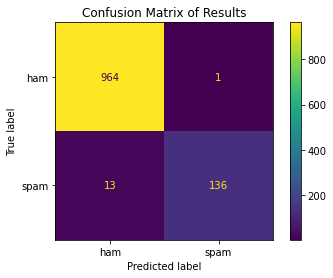

In [21]:
#| code-fold: true
cm = confusion_matrix(y_test, y_pred, labels = ["ham", "spam"])

disp = ConfusionMatrixDisplay(cm, display_labels = ["ham", "spam"])
disp.plot()

plt.title("Confusion Matrix of Results")
plt.show()

In this case, we only have two labels (spam and ham), so there are two rows and two columns. The vertical axis refers to the true labels, whereas the horizontal axis refers to the predicted labels.

For example, if we want to know how many true spam messages were incorrectly predicted to be ham, we can look at the "spam" row and "ham" column. The value is 13, which means that 13 messages were incorrectly predicted in this way.

If we consider ham messages as "negative" and spam messages as "positive," then the confusion matrix above shows the True Negatives (TN) in the top left, False Negatives (FN) in the top right, False Positives (FP) in the bottom left, and True Positives (TP) in the bottom right.

### Recall, Precision, F1

Recall, Precision, and F1 are other metrics of model performance which may be useful when the labels are not represented equally in the data. Their equations are shown below; these were taken from Brownlee (2020).

Recall is the number of true positives divided by the total number of actual positives. It measures the "ability of the classifier to find all the positive samples. (scikit-learn developers, 2021)"

$Recall = \frac{TP}{TP + FN}$

Precision is the number of true positives divided by the total number of predicted positives. It is the "ability of the classifier not to label as positive a sample that is negative" (scikit-learn developers, 2021). In other words, it is the ability of the model to avoid Type I error (Bhandari, 2021).

$Precision = \frac{TP}{TP+FP}$

Finally, $F_{\beta}$ is the "weighted harmonic mean of the precision and recall," and $F_1$ is the version where both of these factors are given equal importance (scikit-learn developers, 2021).

$F1 = \frac{2 TP}{2 TP + FP + FN}$

Let us calculate these metrics for the spam filter using the confusion matrix.

In [22]:
#| code-fold: true
tp = 136
tn = 964
fp = 1
fn = 13

metrics = {}
metrics["recall"] = tp / (tp + fn)
metrics["precision"] = tp / (tp + fp)
metrics["f1"] = 2 * tp / (2 * tp + fp + fn)

for key in metrics:
    print(f"{key}: {metrics[key] * 100:.2f}%")

recall: 91.28%
precision: 99.27%
f1: 95.10%


All three metrics are above 90%. In particular, precision is 99.27%, which means that the model is very good at avoiding labelling ham messages as spam.

Therefore, we can say that the naive bayes algorithm performs very well with the data that it was given.

# scikit-learn Classes for Naive Bayes

In practice, a data scientist would not code the entire algorithm each time they use it, since this is time-consuming. Instead, one can use prepackaged classes in scikit-learn.

For the purpose of classifying spam based on word counts, we can apply the following classes, according to the scikit-learn developers (2021):

- `MultinomialNB`: This uses the same logic as the algorithm explained earlier.
- `GaussianNB`: "The likelihood of the features is assumed to be Gaussian," so the mean and standard deviation of each features is considered.
- `ComplementNB`: It is an "adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets." This may be useful for our dataset because the percentages of spam and non-spam messages are imbalanced.

Other classes which will not be used in this project include `BernoulliNB`, which assumes each feature to be binary (only two categories), and `CategoricalNB`, which assumes that each feature is categorical rather than numeric.

Let us try using the first three classes and comparing them. We will also use functions from `sklearn.metrics` to calculate accuracy score and the other metrics.

In [31]:
#| code-fold: true
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_classes = {
    "Multinomial": MultinomialNB,
    "Gaussian": GaussianNB,
    "Complement": ComplementNB,
}

metric_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1": f1_score,
}

result_rows = []

test_word_counts = to_word_counts(X_test_preprocessed)

for class_name in nb_classes:
    nb = nb_classes[class_name]
    model = nb()
    model.fit(
        word_counts,
        y_train,
    )
    y_pred = model.predict(test_word_counts)

    metric_results = pd.Series(name = class_name, dtype = "float64")

    for metric_name, score_func in metric_funcs.items():
        if metric_name == "Accuracy":
            score = score_func(
                y_true = y_test,
                y_pred = y_pred,
            )
        else:
            score = score_func(
                y_true = y_test,
                y_pred = y_pred,
                pos_label = "spam",
            )
        metric_results[metric_name] = score * 100

    result_rows.append(metric_results)

result_df = pd.DataFrame(result_rows)

result_df

,Accuracy,Precision,Recall,F1
Multinomial,98.743268,99.270073,91.275168,95.104895
Gaussian,90.843806,60.444444,91.275168,72.727273
Complement,97.396768,88.461538,92.617450,90.491803


`MultinomialNB` performed the best, as it had the highest accuracy, precision, and F1 score. Its accuracy was 98.74%, which is the same as the accuracy of the algorithm that I manually coded earlier. Thus, I know that what I coded was correct.

`ComplementNB` also performed well, though its precision was 88%, meaning that it was more prone to labeling ham messages as spam. However, the `GaussianNB` class was the worst performing one, as its precision was 60% and its F1 was 73%. This likely occurred because the assumption that the features' likelihoods were Gaussian did not hold.

# Conclusion

In this project, we obtained a dataset of spam and non-spam messages, used this to calculate the parameters for a multinomial naive bayes algorithm, wrote a function to predict whether a new message is spam or non-spam, evaluated the model using various performance metrics, and tried three variations of the model in scikit-learn.

Naive bayes is just one of various classification models, such as SVM, logistic regression, random forest, etc. It is useful as most of its calculations are done during the training stage, so it is fast at making predictions. However, it is not perfect, as the assumption that the features are independent usually does not hold true in real life. (Gupta, 2020)

However, models cannot represent reality perfectly. Simplifications like this are good enough if they are useful in making predictions or testing relationships among variables.

Another important insight from this project is that accuracy should not be the only metric used to evaluate model performance. We should use other metrics like recall, precision, and F1 score, which provide more nuanced perspectives. Though this was not done for this project, in other scenarios, we may have to adjust the model to favor either recall or precision depending on the specific use case.

Thanks for reading!

# Bibliography

## Data Source

Almeida, T. A., & Hidalgo, J. M. G. (2012, June 22). SMS Spam Collection Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#

## Information Sources

Bhandari, P. (2021, January 18). Type I and Type II errors. Scribbr. https://www.scribbr.com/statistics/type-i-and-type-ii-errors/

Brownlee, J. (2016, November 17). What is a Confusion Matrix in Machine Learning. Machine Learning Mastery. https://machinelearningmastery.com/confusion-matrix-machine-learning/

Brownlee, J. (2020, August 27). How to Calculate Precision, Recall, F1, and More for Deep Learning Models. Machine Learning Mastery. https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

Dataquest. (n.d.). Guided Project: Building A Spam Filter With Naive Bayes. Dataquest. Retrieved December 14, 2021, from https://www.dataquest.io/c/74/m/433/guided-project%3A-building-a-spam-filter-with-naive-bayes

Devanesan, J. (2020, August 19). Phishing scams dominate the Philippines cybercrime landscape. Tech Wire Asia. https://techwireasia.com/2020/08/phishing-scams-dominate-the-philippines-cybercrime-landscape/

FTC CI. (2020, February 19). How To Recognize and Report Spam Text Messages. Federal Trade Commission Consumer Information. https://www.consumer.ftc.gov/articles/how-recognize-and-report-spam-text-messages

Gupta, S. (2020, February 28). Pros and cons of various Classification ML algorithms. Medium. https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6

scikit-learn developers. (2021). 1.9. Naive Bayes. Scikit-Learn. https://scikit-learn/stable/modules/naive_bayes.html

scikit-learn developers. (2021). 3.3. Metrics and scoring: Quantifying the quality of predictions. Scikit-Learn. https://scikit-learn/stable/modules/model_evaluation.html

Thomas, L. (2020, September 18). How to use stratified sampling. Scribbr. https://www.scribbr.com/methodology/stratified-sampling/
Vadapalli, P. (2021, January 5). Naive Bayes Explained: Function, Advantages & Disadvantages, Applications in 2021. UpGrad Blog. https://www.upgrad.com/blog/naive-bayes-explained/

Vallantin, L. (2018, September 6). Why you should not trust only in accuracy to measure machine learning performance. Medium. https://medium.com/@limavallantin/why-you-should-not-trust-only-in-accuracy-to-measure-machine-learning-performance-a72cf00b4516

Yap, C. (2021, November 25). Millions of spam messages blocked in Philippines as scams surge. Yahoo News. https://ph.news.yahoo.com/millions-of-spam-messages-blocked-in-philippines-as-scams-surge-005658569.html

## Image Source

Johnson, H. (2020, February 24). Photo by Hannes Johnson on Unsplash. Unsplash. https://unsplash.com/photos/mRgffV3Hc6c

# Appendix

Here, I explain how the multinomial naive bayes algorithm was derived from the Bayes Theorem. This was originally placed earlier in the post, but I deemed it to be unnecessary for that part.

:::{.callout-note}

The mathematical explanations below are not my own ideas. I learned these from the Dataquest course on Naive Bayes.

:::


Given two events $A$ and $B$, we can use the theorem to determine the probability that $B$ happened given that $A$ happened. This probability is written as $P(B|A)$.

$P(B|A) = \frac{P(B) \cdot P(A|B)}{\Sigma_{i = 1}^n (P(B_i) \cdot P(A|B_i))}$

In this case, $B_1$ is the event that the message is non-spam, and $B_2$ is the event that it is spam. $B$ can refer to either $B_1$ or $B_2$, depending on which probability we want to calculate. Also, $A$ refers to the specific contents of one message.

In order to make things clearer, let us say that $Spam$ is the event that the message is spam, and $Ham$ is the event that the message is non-spam.

Then, let us expand event $A$ (the message itself) in order to consider the individual words inside it. For example, the first word in a message can be labeled $w_1$. If we have a total of $n$ words, then the words can be labeled as $w_1, w_2, \dots , w_n$.

Thus, we can rewrite the equation. Here is the probability of a given message being spam:

$P(Spam|w_1, w_2, \dots , w_n) = \frac{P(Spam) \cdot P(w_1, w_2, \dots , w_n|Spam)}{\Sigma_{i = 1}^n (P(B_i) \cdot P(w_1, w_2, \dots , w_n|B_i))}$

Here is the probability of a given message being non-spam:

$P(Ham|w_1, w_2, \dots , w_n) = \frac{P(Ham) \cdot P(w_1, w_2, \dots , w_n|Ham)}{\Sigma_{i = 1}^n (P(B_i) \cdot P(w_1, w_2, \dots , w_n|B_i))}$

Notice that the denominators are the same. Since we only want to compare these two probabilities, we can skip calculating the denominator and just calculate the numerators. We can thus rewrite the equation as follows. Note that the $\propto$ symbol is used instead of $=$ because the two quantities are not equal but directly proportional.

$P(Spam|w_1, w_2, \dots , w_n) \propto P(Spam) \cdot P(w_1, w_2, \dots , w_n|Spam)$

The first factor, $P(Spam)$, is easy to find, as it is simply the number of spam messages divided by the total number of messages. However, $P(w_1, w_2, \dots , w_n|Spam)$ needs to be further expanded.

If we make the assumption that the probability of each word is independent of the probability of the other words, we can use the multiplication rule. The assumption of independence is what makes the algorithm "naive," as it usually doesn't hold true in reality. However, the algorithm is still useful for predictions despite this.

$P(Spam) \cdot P(w_1, w_2, \dots , w_n|Spam) \\ = P(Spam) \cdot P(w_1 \cap w_2 \cap \dots \cap w_n | Spam) \\ = P(Spam) \cdot P(w_1|Spam) \cdot P(w_2|Spam) \cdot \dots \cdot P(w_n|Spam)$

Note that we still have to find the probability of each word given $Spam$ because we assume that the presence of each word is dependent on $Spam$.

Thus, the final formula is:

$P(Spam|w_1, w_2, \dots , w_n) \propto P(Spam) \cdot \Pi_{i=1}^n P(w_i|Spam)$

Likewise, the formula for $Ham$ is:

$P(Ham|w_1, w_2, \dots , w_n) \propto P(Ham) \cdot \Pi_{i=1}^n P(w_i|Ham)$